# MoLE training

Multifile dataset augmentation and loading

In [1]:
import os
import random

from tqdm.notebook import tqdm

In [2]:
device='cuda'
def generate_response (text_input="Biology offers amazing",
                      num_return_sequences=1,
                      temperature=1., #the higher the temperature, the more creative the model becomes
                      max_new_tokens=127,
                      num_beams=1,
                      top_k = 50,
                      top_p =0.9,repetition_penalty=1.,eos_token_id=2,verbatim=False,
                      exponential_decay_length_penalty_fac=None,
                      ):

    inputs = tokenizer.encode(text_input,  
                              add_special_tokens  =False,  
                              return_tensors ='pt')
    if verbatim:
        print ("Length of input, tokenized: ", inputs.shape, inputs)
    with torch.no_grad():
          print(inputs.shape)
          outputs = model.generate(input_ids=inputs.to(device), 
                                   max_new_tokens=max_new_tokens,
                                   temperature=temperature, #value used to modulate the next token probabilities.
                                   num_beams=num_beams,
                                   top_k = top_k,
                                   top_p =top_p,
                                   num_return_sequences = num_return_sequences, eos_token_id=eos_token_id,
                                   do_sample =True,#skip_prompt=True,
                                   # exponential_decay_length_penalty = [inputs.shape[1], 
                                   #                                     exponential_decay_length_penalty_fac],
                                   # length_penalty =   exponential_decay_length_penalty_fac,
                                    
                    repetition_penalty=repetition_penalty,
                                   #repetition_penalty_range = 2048,
                                    #    repetition_penalty_slope = 0,
                                  )
    return tokenizer.batch_decode(outputs[:,inputs.shape[1]:].detach().cpu().numpy(), skip_special_tokens=True)

In [ ]:
on_Lambda = True

if on_Lambda:
    !python3 -m pip install --upgrade pip
    
    !pip install -U trl git+https://github.com/huggingface/transformers.git git+https://github.com/huggingface/accelerate.git git+https://github.com/huggingface/peft.git
    !pip install -U datasets einops wandb unidecode protobuf==3.20.0 bitsandbytes 
    !pip install -U trl
    !pip install -U scipy
    !pip install -U matplotlib
    
else:
    #os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    os.environ['HUGGINGFACE_HUB_CACHE '] = "/mnt/d/.cache_Huggingface/"
    os.environ['HF_HOME'] = "/mnt/d/.cache_Huggingface/"


In [3]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import transformers
from datasets import load_dataset
from datasets import IterableDataset

from transformers import Trainer
from transformers import TrainingArguments
from transformers import DataCollatorWithPadding
from transformers import TrainerCallback
from transformers import AutoConfig
from transformers import BitsAndBytesConfig

from peft import LoraConfig, get_peft_model
from torch.utils.data import Dataset
from transformers import get_linear_schedule_with_warmup

import math
import numpy as np
import unidecode
import pandas as pd
from matplotlib import pyplot as plt

In [4]:
import mole

In [5]:
torch.version.cuda, torch.__version__, torch.backends.cudnn.version(), torch.backends.cudnn.enabled, torch.cuda.is_available()

('12.1', '2.1.2', 8902, True, True)

In [6]:
torch.cuda.get_device_name(), torch.cuda.device_count()

('NVIDIA RTX A6000', 1)

In [7]:
for i in range(torch.cuda.device_count()):
   print(torch.cuda.get_device_properties(i).name)

NVIDIA RTX A6000


In [8]:
device = torch.device("cuda")

In [9]:
token = 'hf_xxxxxxxxxxxxxxxxxxxxxxxxx'
from huggingface_hub import login
#login(token=token)

### Parameters

In [10]:
epochs = 5
learning_rate = 1e-4
#warmup_steps = 1e2
epsilon = 1e-8
batch_size=1 
train_test_split = 1 #80% of the FILES
gradient_accumulation_steps=1

output_dir = 'Mistral_v200Zephyr'
FT_model_name = 'Mistral_v200Zephyr' #BioLlama_7b_4bit_190_withend
loss_file='Mistral_v200Zephyr.csv'

In [11]:
def params(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])

    print("Parameters: ", params) 

In [12]:
#del model

In [13]:
from accelerate import infer_auto_device_map

In [14]:
model_name= 'HuggingFaceH4/zephyr-7b-beta'

bnb_config4bit = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    #bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_compute_dtype=torch.bfloat16,
    use_nested_quant = False,
)

bnb_config8bit = BitsAndBytesConfig(
    load_in_8bit=True,
    #bnb_8bit_compute_dtype=torch.bfloat16,
    bnb_8bit_compute_dtype=torch.bfloat16,
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    #quantization_config= bnb_config8bit, 
    #quantization_config= bnb_config4bit, #bnb_config,
    trust_remote_code=True,
    #load_in_8bit=True, 
    device_map="auto",
    torch_dtype=  torch.bfloat16,
   # use_flash_attention_2=True,
    #device_map="cuda:0",
)#.to (device)
model.config.use_cache = False


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

In [15]:
model_name= 'HuggingFaceH4/zephyr-7b-beta'
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True,
                                         #device_map="cuda:0",
                                          device_map="auto",
                                         )
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right" # Fix weird overflow issue with fp16 training
tokenizer.add_bos_token, tokenizer.add_eos_token
#tokenizer.padding_side = "left" # Fix weird overflow issue with fp16 training
eos_token= tokenizer.eos_token_id

In [16]:
tokenizer.pad_token

'</s>'

In [17]:
messages = [
    {
        "role": "system",
        "content": "You are a friendly chatbot who always responds in the style of a pirate",
    },
    {"role": "user", "content": "How many helicopters can a human eat in one sitting?"},
    {"role": "assistant", "content": "Sample response."},
]
prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
prompt

'<|system|>\nYou are a friendly chatbot who always responds in the style of a pirate</s>\n<|user|>\nHow many helicopters can a human eat in one sitting?</s>\n<|assistant|>\nSample response.</s>\n<|assistant|>\n'

In [18]:
pwd

'/root/mole'

### Set up LoRA model (adaptors)

In [20]:

from transformers import AutoModelForCausalLM, AutoConfig
import mole
 
from importlib import reload
import torch

mole=reload(mole)

config = AutoConfig.from_pretrained(model_name)
model = mole.add_mole_to_model(model = model,
                              
                       mole_config = mole.MoLEConfig(config.hidden_size, mole_depth=2,
                                pad_token_id=tokenizer.pad_token_id, device=torch.device("cuda")),
                     verbose=True,
                       adapters = {"adapter_1": "./mole-checkpoints/checkpoint-a", 
                                   "adapter_2": "./mole-checkpoints/checkpoint-a",
                                  })


100%|██████████| 2376/2376 [00:00<00:00, 1033032.68it/s]

Swapped 160 layers.


In [21]:
config.vocab_size

32000

In [22]:
params (model)

Parameters:  0


In [23]:
mole.print_trainable_parameters(model)

trainable params: 131,136 || all params: 14,575,870,016 || trainable%: 0.0009


In [24]:
model

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096, padding_idx=2)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralSdpaAttention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (adapter_1): Dropout(p=0.05, inplace=False)
                  (adapter_2): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (adapter_1): Linear(in_features=4096, out_features=16, bias=False)
                  (adapter_2): Linear(in_features=4096, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (adapter_1): Linear(in_features=16, out_features=4096, bias=False)
                  (adapter_2): Linear(in_feature

In [25]:
model, mole.print_trainable_parameters(model)

trainable params: 131,136 || all params: 14,575,870,016 || trainable%: 0.0009


(PeftModelForCausalLM(
   (base_model): LoraModel(
     (model): MistralForCausalLM(
       (model): MistralModel(
         (embed_tokens): Embedding(32000, 4096, padding_idx=2)
         (layers): ModuleList(
           (0-31): 32 x MistralDecoderLayer(
             (self_attn): MistralSdpaAttention(
               (q_proj): lora.Linear(
                 (base_layer): Linear(in_features=4096, out_features=4096, bias=False)
                 (lora_dropout): ModuleDict(
                   (adapter_1): Dropout(p=0.05, inplace=False)
                   (adapter_2): Dropout(p=0.05, inplace=False)
                 )
                 (lora_A): ModuleDict(
                   (adapter_1): Linear(in_features=4096, out_features=16, bias=False)
                   (adapter_2): Linear(in_features=4096, out_features=16, bias=False)
                 )
                 (lora_B): ModuleDict(
                   (adapter_1): Linear(in_features=16, out_features=4096, bias=False)
                   (adapter_

In [26]:
print (dir(mole))

['MoLEConfig', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'add_mole_to_model', 'from_pretrained', 'get_nb_trainable_parameters', 'mole', 'mole_classifier', 'mole_config', 'mole_insertion', 'mole_state', 'print_trainable_parameters', 'save_pretrained', 'set_scalings_with_lifetime']


In [27]:
tokenizer.add_bos_token=True #False

In [28]:
import pandas as pd
  
fname='./BioMat_ExaminationsQ_UPDATED.csv'
df_trial=pd.read_csv(fname)
df_trial

eos_token=tokenizer.eos_token_id

def trial(df_trial, step_number=0, frac=1. ):

    questions=[]
    answers=[]
    corr_answers=[]

    if frac<1:
        df_trial=df_trial.sample (frac=frac, random_state=42).reset_index()
    
    for q,CorrectA in tqdm(zip(df_trial['Question'],df_trial['Answer'])):    
        print ("###########################################################################")
        #q=f'Select only one option as the correct answer (A,  B, or C): "{q.strip()}"'
        #q=f'{q.strip()}'
        
        #txt=f"<s>### System:\n{system_prompt}\n\n### User:\n{q}\n\n### Assistant:\n{prepend_response}" 
        
        #txt=system_prompt+f"Select only one option as the correct answer (A,  B, or C): " + q + "[/INST]"
        #txt=f"[INST] {q} [/INST]"
        #txt=f"<s>{system_prompt} [INST] Select only one option as the correct answer (A,  B, or C): " + q + "[/INST]"
        #txt=f"<s>[INST] Select only one option as the correct answer (A,  B, or C): " + q + "[/INST]"
        #txt=f"<s>Select the correct answer</s><s>. [INST] " + q + "[/INST]"
        #txt=f"<s>You are an expert in biological and bio-inspired materials. [INST] Select only one option as the correct answer (A,  B, or C): " + q + ". Very brief answer. [/INST]"
        txt=f"<s><|user|>\nSelect only one option as the correct answer (A,  B, or C): " + q.strip() + "</s>\n<|assistant|>\n"

        #'<|system|>\nYou are a friendly chatbot who always responds in the style of a pirate</s>\n<|user|>\nHow many helicopters 
        #can a human eat in one sitting?</s>\n<|assistant|>\n

        
        #txt=f"<s>You are an expert in biological and bio-inspired materials. [INST] Read this question: "+ q + "Select only one option as the correct answer (A,  B, or C): " + q + "[/INST]"
        #txt=f"<s> Select only one option as the correct answer (A,  B, or C): " + q  
        #print (f"QUESTION: {txt}")
        #txt=f"<s>{q}"
        #txt=f"<s>### User:\n{q}\n\n### Assistant:\n{prepend_response}" 
        #print (txt) 
        #result=generate_response ("[INST] Select only one option as the correct answer (A,  B, or C): " + csv_data_list[l] + "[/INST]",repetition_penalty = 1.1, \
        #temperature=.1,max_new_tokens=100,num_return_sequences=5) 
    
        
        output_text=generate_response (text_input=txt,eos_token_id=eos_token,
                              num_return_sequences=1,  repetition_penalty=1.,
                                       # top_p=0.95, top_k=500, 
                                       top_p=0.9, top_k=50,  
                             #temperature=.1,max_new_tokens=100, verbatim=True, 
                             temperature=.1,max_new_tokens=256, verbatim=False, 
                                        
                                       )
      
        
        #print("\nANSWER: ", output_text[0],'\n')
        print (f"Question: {q}\nAnswer: {output_text[0]}\nCorrect answer={CorrectA}")
        questions.append (q)
        answers.append (output_text[0])
        corr_answers.append (CorrectA)

    
    df_res = pd.DataFrame({"text": questions, "answers": answers, "corr_answers": corr_answers} )
    df_res.to_csv(f'./{output_dir}/out_{FT_model_name}_{step_number}.csv')

    return df_res


In [29]:
eos_token

2

### Data loader and related functions 

  0%|          | 0/22283 [00:00<?, ?it/s]

Max tokenized: 511, max length (words): 386


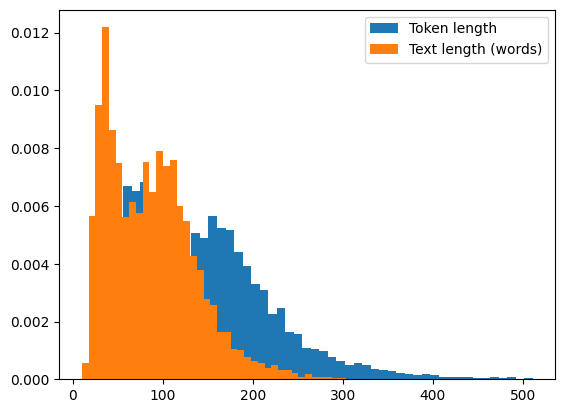

In [30]:
### ALTERNATIVE DATALOADER

    
#start_token = '<s>'
#end_token = '</s>'
#sys_token = '<<SYS>>'
#or_start_token = '[INST]'
#or_end_token = '[/INST]' 

pad_all=False #then padding happens in data collector 

# Create torch dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, text_list):
        #self.titles = df['Article Title']
        #self.abstracts = df['Abstract']
        self.textlist=text_list

    def __getitem__(self, idx):
         
        #line =  f"{inst_start_token} {self.titles[idx]} {inst_end_token} {self.abstracts[i]} {end_token}"
        line =  self.textlist[idx]
        #print (line[:16])
        #print (f'{idx}-', end='')
        
        if text_only:
            out = {
                   "text": line
                  }
        
        elif pad_all:
            res = tokenizer(line, truncation=True, max_length=MAX_TOKENIZED_LENGTH, 
                                    padding="max_length",
                                    return_tensors="pt",
                                   
                                   )

            out = {
                   "input_ids": res["input_ids"].squeeze(), "attention_mask":res["attention_mask"].squeeze(),
                   "labels": res["input_ids"].clone().detach().squeeze()#,
                   #"text": line
                  }
        
        else:
            res = tokenizer(line, #truncation=True, max_length=MAX_TOKENIZED_LENGTH, 
                                   # padding="max_length",
                                    return_tensors="pt",
                                   
                                   )
    
            out = {
                   "input_ids": res["input_ids"].squeeze(), "attention_mask":res["attention_mask"].squeeze(),
                   "labels": res["input_ids"].clone().detach().squeeze()#,
                   #"labels": res["input_ids"].clone().detach().squeeze(),
                   #"text": line
                  }
        
        #print (item)
        return out

    def __len__(self):
        return len(self.textlist)



max_leng_critical=1800
max_leng_critical=512

max_len=-1
max_len_txt=-1
len_list=[]
len_list_txt=[]
text_list=[]

use13b=True
Orca_include=True
Orca_singleout_include=True
#numerical_include=False
numerical_include=True

use13b=False
Orca_include=False
Orca_singleout_include=False
#numerical_include=False
numerical_include=False

CoT_include=False #True

Q_A_include=True
format_qa=True #whether to use chat template 

if Q_A_include:
    
    data=pd.read_csv('train_data_processed_Mistral_train_data_small_COMBINED.csv_0_FINAL.csv')
    
    for idx in tqdm ( range (len (data['question'])) ):
        
        #system_prompt='You are BioinspiredLLM, a helpful assistant.'
        
        if format_qa:

            messages = [
             
            {"role": "user", "content": data['question'][idx]},
            {"role": "assistant", "content": data['answer'][idx]},
            
            ]
            line = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=False)

        else:
            line=f"{data['question'][idx]} {data['answer'][idx]}</s>" 



        
        tok=tokenizer(line,  return_tensors="pt",  )
    
        if tok['input_ids'].shape[1]<max_leng_critical:
            
            if tok['input_ids'].shape[1]>=max_len:
                max_len=tok['input_ids'].shape[1]
        
                
                #print (len (line.split ()))
            if len (line.split ())>max_len_txt:
                max_len_txt=len (line.split ())
        
            len_list.append (tok['input_ids'].shape[1])
            len_list_txt.append (len (line.split ()))
        
            text_list.append (line)



if CoT_include:
    max_leng_critical_CoT=1000
    
    data=pd.read_csv('ALLDATASETS/13b_train_data_smallv2_processed_llama_B_MERGED.csv')

    dataset = load_dataset('json', data_files="./CoT_data.json", )


    for item in tqdm (dataset["train"]):
        
        messages = [
         
        {"role": "user", "content": item['instruction']},
        {"role": "assistant", "content": item['output']},
        
        ]
        line = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=False)
    
        tok=tokenizer(line,  return_tensors="pt",  )
    
        if tok['input_ids'].shape[1]<max_leng_critical_CoT:
            
            if tok['input_ids'].shape[1]>=max_len:
                max_len=tok['input_ids'].shape[1]
        
                
                #print (len (line.split ()))
            if len (line.split ())>max_len_txt:
                max_len_txt=len (line.split ())
        
            len_list.append (tok['input_ids'].shape[1])
            len_list_txt.append (len (line.split ()))
        
            text_list.append (line)


if use13b:
    
    data=pd.read_csv('../ALLDATASETS/13b_train_data_smallv2_processed_llama_B_MERGED.csv')
    
    for idx in tqdm ( range (len (data['question'])) ):
        '''
        <s>[INST] <<SYS>>
        You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.  Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.
        
        If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.
        <</SYS>>
        
        There's a llama in my garden 😱 What should I do? [/INST]
        '''
        system_prompt='You are BioinspiredLLM, a helpful assistant.'
        ########################################################
        #line=f"{CNT['text'][idx]}{end_token}"
        #line=f"{or_start_token} {CNT['question'][idx]} {or_end_token} {CNT['answer'][idx]} {end_token}" 
        #line=f"<|user|>\n{data['question'][idx]}</s>\n<|assistant|>\n{data['answer'][idx]}</s>" 
        line=f"{data['question'][idx]} {data['answer'][idx]}</s>" 
        #prompt =  f"<|im_start|>system\n{system_prompt}<|im_end|>\n<|im_start|>user\n{user_message}<|im_end|>\n<|im_start|>assistant"
    
    
    
        #line = f"[INST]\n<<SYS>>\n{system_prompt}\n<</SYS>>\n\n{data['question'][idx]}[/INST]{data['answer'][idx]}</s>"
        #line = f"[INST]\n<<SYS>>\n{system_prompt}\n<</SYS>>\n\n{data['question'][idx]}[/INST]{data['answer'][idx]}</s>"
    
        #line=f"{data['question'][idx]} {data['answer'][idx]}" 
        tok=tokenizer(line,  return_tensors="pt",  )
    
        if tok['input_ids'].shape[1]<max_leng_critical:
            
            if tok['input_ids'].shape[1]>=max_len:
                max_len=tok['input_ids'].shape[1]
        
                
                #print (len (line.split ()))
            if len (line.split ())>max_len_txt:
                max_len_txt=len (line.split ())
        
            len_list.append (tok['input_ids'].shape[1])
            len_list_txt.append (len (line.split ()))
        
            text_list.append (line)


if Orca_singleout_include:
    fname='ALLDATASETS/train_data_processed_OpenOrca_singleoutput_train_data_chunked_text.csv_0_Lambda_0_FINAL.csv'
    data=pd.read_csv(fname)
    #data.head ()
    for idx in tqdm ( range (len (data['title'])) ):
        '''
        <s>[INST] <<SYS>>
        You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.  Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.
        
        If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.
        <</SYS>>
        
        There's a llama in my garden 😱 What should I do? [/INST]
        '''
        system_prompt='You are BioinspiredLLM, a helpful assistant.'
        ########################################################
        #line=f"{CNT['text'][idx]}{end_token}"
        #line=f"{or_start_token} {CNT['question'][idx]} {or_end_token} {CNT['answer'][idx]} {end_token}" 
        #line=f"<|user|>\n{data['question'][idx]}</s>\n<|assistant|>\n{data['answer'][idx]}</s>" 
        #line=f"{data['title'][idx]} {data['summary'][idx]} {data['key_fact'][idx]}</s>" 
        line=f"{data['summary'][idx]}</s>" 
        #prompt =  f"<|im_start|>system\n{system_prompt}<|im_end|>\n<|im_start|>user\n{user_message}<|im_end|>\n<|im_start|>assistant"
    
    
    
        #line = f"[INST]\n<<SYS>>\n{system_prompt}\n<</SYS>>\n\n{data['question'][idx]}[/INST]{data['answer'][idx]}</s>"
        #line = f"[INST]\n<<SYS>>\n{system_prompt}\n<</SYS>>\n\n{data['question'][idx]}[/INST]{data['answer'][idx]}</s>"
    
        #line=f"{data['question'][idx]} {data['answer'][idx]}" 
        tok=tokenizer(line,  return_tensors="pt",  )
    
        if tok['input_ids'].shape[1]<max_leng_critical:
            
            if tok['input_ids'].shape[1]>=max_len:
                max_len=tok['input_ids'].shape[1]
        
                
                #print (len (line.split ()))
            if len (line.split ())>max_len_txt:
                max_len_txt=len (line.split ())
        
            len_list.append (tok['input_ids'].shape[1])
            len_list_txt.append (len (line.split ()))
        
            text_list.append (line)
    print (f"Max tokenized: {max_len}, max length (words): {max_len_txt}")
    MAX_TOKENIZED_LENGTH=max_len
    
    
if Orca_include:
    data=pd.read_csv('ALLDATASETS/train_data_processed_OpenOrca_shorter_train_data_chunked_text.csv_0_Lambda_0_FINAL.csv')
    #data.head ()
    for idx in tqdm ( range (len (data['title'])) ):
        '''
        <s>[INST] <<SYS>>
        You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.  Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.
        
        If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.
        <</SYS>>
        
        There's a llama in my garden 😱 What should I do? [/INST]
        '''
        system_prompt='You are BioinspiredLLM, a helpful assistant.'
        ########################################################
        #line=f"{CNT['text'][idx]}{end_token}"
        #line=f"{or_start_token} {CNT['question'][idx]} {or_end_token} {CNT['answer'][idx]} {end_token}" 
        #line=f"<|user|>\n{data['question'][idx]}</s>\n<|assistant|>\n{data['answer'][idx]}</s>" 
        line=f"{data['title'][idx]} {data['summary'][idx]} {data['key_fact'][idx]}</s>" 
        #prompt =  f"<|im_start|>system\n{system_prompt}<|im_end|>\n<|im_start|>user\n{user_message}<|im_end|>\n<|im_start|>assistant"
    
    
    
        #line = f"[INST]\n<<SYS>>\n{system_prompt}\n<</SYS>>\n\n{data['question'][idx]}[/INST]{data['answer'][idx]}</s>"
        #line = f"[INST]\n<<SYS>>\n{system_prompt}\n<</SYS>>\n\n{data['question'][idx]}[/INST]{data['answer'][idx]}</s>"
    
        #line=f"{data['question'][idx]} {data['answer'][idx]}" 
        tok=tokenizer(line,  return_tensors="pt",  )
    
        if tok['input_ids'].shape[1]<max_leng_critical:
            
            if tok['input_ids'].shape[1]>=max_len:
                max_len=tok['input_ids'].shape[1]
        
                
                #print (len (line.split ()))
            if len (line.split ())>max_len_txt:
                max_len_txt=len (line.split ())
        
            len_list.append (tok['input_ids'].shape[1])
            len_list_txt.append (len (line.split ()))
        
            text_list.append (line)
    print (f"Max tokenized: {max_len}, max length (words): {max_len_txt}")
    MAX_TOKENIZED_LENGTH=max_len
    


if numerical_include:
    
    data=pd.read_csv('ALLDATASETS/train_data_processed_GPT35-numerical_train_data_chunked_text-COMBINED.csv')
    #data.head ()
    for idx in tqdm ( range (len (data['title'])) ):
        '''
        <s>[INST] <<SYS>>
        You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.  Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.
        
        If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.
        <</SYS>>
        
        There's a llama in my garden 😱 What should I do? [/INST]
        '''
        system_prompt='You are BioinspiredLLM, a helpful assistant.'
        ########################################################
        #line=f"{CNT['text'][idx]}{end_token}"
        #line=f"{or_start_token} {CNT['question'][idx]} {or_end_token} {CNT['answer'][idx]} {end_token}" 
        #line=f"<|user|>\n{data['question'][idx]}</s>\n<|assistant|>\n{data['answer'][idx]}</s>" 
        
        if data['summary'][idx] != '':
            line=f"{data['summary'][idx]}</s>" 
            #prompt =  f"<|im_start|>system\n{system_prompt}<|im_end|>\n<|im_start|>user\n{user_message}<|im_end|>\n<|im_start|>assistant"
        
        
        
            #line = f"[INST]\n<<SYS>>\n{system_prompt}\n<</SYS>>\n\n{data['question'][idx]}[/INST]{data['answer'][idx]}</s>"
            #line = f"[INST]\n<<SYS>>\n{system_prompt}\n<</SYS>>\n\n{data['question'][idx]}[/INST]{data['answer'][idx]}</s>"
        
            #line=f"{data['question'][idx]} {data['answer'][idx]}" 
            tok=tokenizer(line,  return_tensors="pt",  )
        
            if tok['input_ids'].shape[1]<max_leng_critical:
                
                if tok['input_ids'].shape[1]>=max_len:
                    max_len=tok['input_ids'].shape[1]
            
                    
                    #print (len (line.split ()))
                if len (line.split ())>max_len_txt:
                    max_len_txt=len (line.split ())
            
                len_list.append (tok['input_ids'].shape[1])
                len_list_txt.append (len (line.split ()))
            
                text_list.append (line)
    
    
    
    data=pd.read_csv('ALLDATASETS/train_data_processed_GPT35-numerical_train_data_chunked_text_v3_REPEAT.csv')
    #data.head ()
    for idx in tqdm ( range (len (data['title'])) ):
        '''
        <s>[INST] <<SYS>>
        You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.  Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.
        
        If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.
        <</SYS>>
        
        There's a llama in my garden 😱 What should I do? [/INST]
        '''
        system_prompt='You are BioinspiredLLM, a helpful assistant.'
        ########################################################
        #line=f"{CNT['text'][idx]}{end_token}"
        #line=f"{or_start_token} {CNT['question'][idx]} {or_end_token} {CNT['answer'][idx]} {end_token}" 
        #line=f"<|user|>\n{data['question'][idx]}</s>\n<|assistant|>\n{data['answer'][idx]}</s>" 
        
        if data['summary'][idx] != '':
            line=f"{data['summary'][idx]}</s>" 
            #prompt =  f"<|im_start|>system\n{system_prompt}<|im_end|>\n<|im_start|>user\n{user_message}<|im_end|>\n<|im_start|>assistant"
        
        
        
            #line = f"[INST]\n<<SYS>>\n{system_prompt}\n<</SYS>>\n\n{data['question'][idx]}[/INST]{data['answer'][idx]}</s>"
            #line = f"[INST]\n<<SYS>>\n{system_prompt}\n<</SYS>>\n\n{data['question'][idx]}[/INST]{data['answer'][idx]}</s>"
        
            #line=f"{data['question'][idx]} {data['answer'][idx]}" 
            tok=tokenizer(line,  return_tensors="pt",  )
        
            if tok['input_ids'].shape[1]<max_leng_critical:
                
                if tok['input_ids'].shape[1]>=max_len:
                    max_len=tok['input_ids'].shape[1]
            
                    
                    #print (len (line.split ()))
                if len (line.split ())>max_len_txt:
                    max_len_txt=len (line.split ())
            
                len_list.append (tok['input_ids'].shape[1])
                len_list_txt.append (len (line.split ()))
            
                text_list.append (line)
print (f"Max tokenized: {max_len}, max length (words): {max_len_txt}")
MAX_TOKENIZED_LENGTH=max_len

import random

 
# Shuffle the list
random.shuffle(text_list)

text_only=False #True
#text_only=True #True

if text_only:
    import datasets 
    df_out = pd.DataFrame({"text": text_list,})
    train_dataset = datasets.Dataset.from_pandas(df_out)
    
else:
    train_dataset = Dataset(text_list )



n_fragments=len (text_list)
len (train_dataset), isinstance(train_dataset, torch.utils.data.Dataset)
#MAX_TOKENIZED_LENGTH=768

plt.hist (len_list, label = 'Token length', density=True, bins=50)
plt.hist (len_list_txt, label = 'Text length (words)', density=True, bins=50)
plt.legend ()
plt.savefig ('dist.svg')
plt.show()

In [31]:
max_len

511

In [32]:
MAX_TOKENIZED_LENGTH

511

In [33]:
text_list[:6]

['<|user|>\n Question: What is the dominant fracture path observed in the shell structure being studied in the investigation?</s>\n<|assistant|>\n The dominant fracture path observed in the shell structure being studied in the investigation is along lamella boundaries.</s>\n',
 '<|user|>\n What is the difference between the crystallographic orientation of the major structural units in the primary plates and the lamellar needle complex?</s>\n<|assistant|>\n The crystallographic orientation of the major structural units in the primary plates and the lamellar needle complex is different. In the primary plates, the major structural units are oriented in two different directions: (a) orange to red at the outermost margin of the primary plates and (b) light green at the inter with the stone. In contrast, the major structural units in the lamellar needle complex are oriented in a different direction, with no specific orientation patterns mentioned.</s>\n',
 '<|user|>\n What were the results o

In [34]:
MAX_TOKENIZED_LENGTH

511

In [35]:
iterator=iter (train_dataset)
for i in range (4):# (len (train_dataset)):
    #print (next (iterator)['text'] )
    print (next (iterator)['input_ids'].shape )
    print (next (iterator)['input_ids'] )
    #print (next (iterator)['text'])

torch.Size([62])
tensor([    1,   523, 28766,  1838, 28766, 28767,    13,  1824,   349,   272,
         5133,  1444,   272, 26148,   455, 12293, 18159,   302,   272,  3014,
        21431,  8007,   297,   272,  6258, 19762,   304,   272,   305,   314,
          479,   283, 25710,  4630, 28804,     2, 28705,    13, 28789, 28766,
          489, 11143, 28766, 28767,    13,   415, 26148,   455, 12293, 18159,
          302,   272,  3014, 21431,  8007,   297,   272,  6258, 19762,   304,
          272,   305,   314,   479,   283, 25710,  4630,   349,  1581, 28723,
          560,   272,  6258, 19762, 28725,   272,  3014, 21431,  8007,   460,
         9093,   286,   297,   989,  1581, 14278, 28747,   325, 28708, 28731,
        14545,   298,  2760,   438,   272, 12859,  2284,  9829,   302,   272,
         6258, 19762,   304,   325, 28726, 28731,  2061,  5344,   438,   272,
          791,   395,   272,  7253, 28723,   560,  9349, 28725,   272,  3014,
        21431,  8007,   297,   272,   305,   31

In [36]:
tokenizer.pad_token_id

2

In [37]:
#keep norm layers in high accuracy 
#for name, module in model.named_modules():
#    if "norm" in name:
#        module = module.to(torch.float16)

In [38]:
batch_size

1

In [39]:
epochs=5

### Set up training parameters, and train 

In [40]:
total_steps =  int (epochs*  (int (n_fragments*train_test_split )//batch_size )/gradient_accumulation_steps)
steps_per_epoch=total_steps//epochs

In [41]:
warmup_ratio=0.01
warmupsteps=int (total_steps*0.01)

In [42]:
total_steps, steps_per_epoch, warmupsteps

(110705, 22141, 1107)

In [43]:
class push_callback(TrainerCallback):
    def on_save(self, args, state, control, **kwargs):

        try:
            print ("Step: Pushing model...", state.global_step )
            model.push_to_hub(FT_model_name, private=True)  
            
        except:
            print ("Push error...", state.global_step )
        #tokenizer.push_to_hub(FT_model_name, private=True)  

        #try:
        #    model.save_pretrained (output_dir+"/checkpoint")

        try:
            df=pd.DataFrame(trainer.state.log_history)
            df.to_csv(output_dir+loss_file)
    
            plt.plot (df['step'], df['loss'], 'o-', label = 'Training loss', )
            plt.legend ()
            plt.ylabel ('Loss')
            plt.xlabel  ('Step')
            plt.savefig(output_dir+f'/loss_{state.global_step}.svg')
            plt.show()
        except:
            print ("Plotting failed.")

        try:
            #result=generate_response (text_input=f"{start_token}[INST]To create a tough and strong soft material using a biomimetic collagen design, what do I do? [/INST]",num_return_sequences=1,
            #                         temperature=.5,max_new_tokens=128)

            #trial ()
            df_res=trial (df_trial,step_number=state.global_step, frac= 1)
            
            
        except:
            print ("Trial generation failed.")
        

In [ ]:
df_res=trial (df_trial,step_number=223, frac= 1)

0it [00:00, ?it/s]

###########################################################################
torch.Size([1, 58])


/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1547: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


Question: When describing gradient structures, they can be gradients in? A) dimension B) composition C) both dimension and composition
Answer: C) both dimension and composition is the correct answer when describing gradient structures. Gradient structures can exhibit gradients in both dimension and composition. This means that the properties of the material, such as composition, crystal structure, or magnetic properties, can vary smoothly and gradually in both spatial and compositional directions. Gradient structures are commonly used in materials science and engineering to tailor the properties of materials for specific applications.
Correct answer=C
###########################################################################
torch.Size([1, 63])


In [ ]:
1+"A"

In [ ]:
from transformers import TrainingArguments

output_dir = output_dir
per_device_train_batch_size = batch_size
gradient_accumulation_steps = gradient_accumulation_steps
#optim = "paged_adamw_32bit"
optim = "paged_adamw_8bit"
save_steps = steps_per_epoch
logging_steps = steps_per_epoch
learning_rate = learning_rate
max_grad_norm = 0.3
max_steps = total_steps
 
lr_scheduler_type = "constant"

training_arguments = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    #fp16=True,
    bf16=True, #on A100
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    #group_by_length=True,
    lr_scheduler_type=lr_scheduler_type,
    save_total_limit=50,
    report_to= "none", #change if you want to use wandb
)

In [ ]:
 FT_model_name

In [ ]:
train_dataset[0]

In [ ]:
from trl import SFTTrainer
from transformers import   DataCollatorForLanguageModeling, DataCollatorForSeq2Seq
#max_seq_length = MAX_TOKENIZED_LENGTH



'''
trainer = SFTTrainer(
    model=model,
    train_dataset=train_data, #dataset, #train_data,
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
)
'''

trainer = Trainer(
        model=model,
        train_dataset=train_dataset,
        args=training_arguments,
        #data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False),
   data_collator=DataCollatorForSeq2Seq(tokenizer, return_tensors='pt', padding=True),
    callbacks=[push_callback],
    )



In [ ]:
len (train_dataset)

In [ ]:
#model.to('cuda')

In [ ]:
#for name, module in model.named_modules():
#    if "norm" in name:
#        module = module.to(torch.float16)

In [ ]:
#df_res=trial (df_trial,step_number=223, frac= 1)

In [ ]:
trainer.train()

In [ ]:
trainer.train(resume_from_checkpoint = f'./{FT_model_name}/tmp-checkpoint-15390//')